# 305to320 (1-15 November)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('T:\\COVID19\\Makrodaten\\Nov1-15woPe deaths.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_leth_AGS_305to320']
X = df.loc[:, ~df.columns.isin(['std_leth_AGS_305to320'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  155


# First CatBoost Model with 155 features

In [4]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9987305311376165


In [5]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  0.14559729561024076


# SHAP VAlues

In [6]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

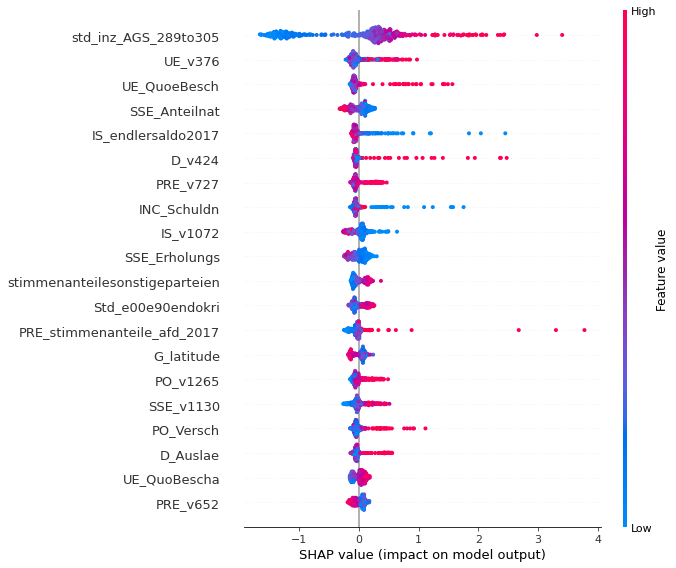

In [7]:
shap.summary_plot(shap_values_cb,X)

# Second CatBoost model with 20 most important features

In [8]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [9]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9917701195461648


In [10]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  0.3707140492743299


# Compare top 10 features of both Models

In [11]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_AGS_289to305', 'UE_v376', 'UE_QuoeBesch', 'SSE_Anteilnat', 'IS_endlersaldo2017', 'D_v424', 'PRE_v727', 'INC_Schuldn', 'IS_v1072', 'SSE_Erholungs'] 

 10 most important features from model with top20 features: 
 ['std_inz_AGS_289to305', 'SSE_Anteilnat', 'UE_v376', 'UE_QuoBescha', 'PRE_v652', 'UE_QuoeBesch', 'SSE_v1130', 'IS_endlersaldo2017', 'D_v424', 'PO_Versch']


In [12]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_AGS_289to305
UE_v376
UE_QuoeBesch
SSE_Anteilnat
IS_endlersaldo2017
D_v424


ABS_SHAP(shap_values_cb_20,X[top20feature]) 

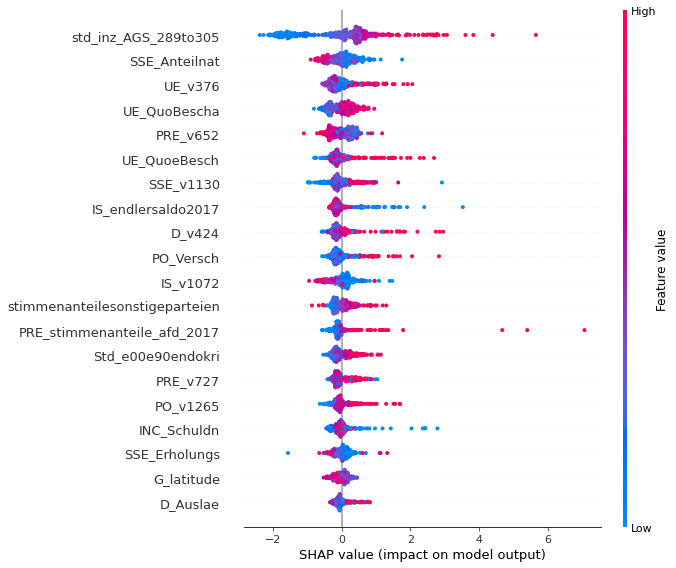

In [13]:
shap.summary_plot(shap_values_cb_20,X[top20feature])

# Hold out validation of the second model

In [14]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [15]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.994802824765307
Mean R2 of linReg_modesl with top20 features:  0.27779258019641756
Mean RMSE of CatBoost_models on test sets with top20 features:  3.5662262663013893
Mean R2 of CatBoost_models on test sets with top20 features: 0.23574985560646367


# descriptives of top20 features

In [16]:
X[top20feature].describe()

,std_inz_AGS_289to305,UE_v376,UE_QuoeBesch,SSE_Anteilnat,IS_endlersaldo2017,D_v424,PRE_v727,INC_Schuldn,IS_v1072,SSE_Erholungs,stimmenanteilesonstigeparteien,Std_e00e90endokri,PRE_stimmenanteile_afd_2017,G_latitude,PO_v1265,SSE_v1130,PO_Versch,D_Auslae,UE_QuoBescha,PRE_v652
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,196.861191,20.240162,49.557602,5.101745,-10.362344,2.212468,11.654364,9.687283,531.122192,70.509460,5.217952,64.049629,13.388280,50.615307,48.195263,-86.781769,1682.694702,10.034916,52.529179,3.814213
std,100.082146,4.537330,5.944391,3.710642,29.724245,2.777426,3.181232,2.725502,495.516693,56.734703,1.823041,15.094089,5.329521,1.740311,1.583288,6.361413,1549.749634,5.149191,3.597842,1.137749
min,21.628151,10.800000,29.600000,0.900000,-149.399994,-4.600000,4.600000,3.700000,103.000000,14.000000,2.000000,0.000000,4.900000,47.500000,42.799999,-93.599998,0.000000,1.900000,40.400002,0.000000
25%,124.023865,17.000000,45.700001,2.700000,-25.299999,0.400000,10.300000,7.700000,223.000000,39.700001,3.800000,54.863358,9.800000,49.283333,47.400002,-88.199997,649.700012,6.200000,50.500000,3.000000
50%,180.949234,19.299999,49.900002,4.300000,-12.000000,2.300000,12.100000,9.400000,360.000000,52.799999,4.700000,63.261333,12.000000,50.549999,48.400002,-87.500000,1167.900024,9.200000,52.700001,3.800000
75%,250.004318,22.400000,53.599998,6.300000,4.800000,4.100000,13.800000,11.000000,617.000000,76.699997,6.600000,72.358131,15.300000,51.849998,49.200001,-86.500000,2247.600098,13.100000,55.099998,4.600000
max,613.031067,38.500000,66.400002,34.000000,62.700001,11.700000,20.400000,20.799999,4338.000000,384.600006,12.600000,112.477448,35.500000,54.783333,51.900002,0.000000,9908.299805,35.000000,60.799999,7.700000


In [17]:
pd.DataFrame(Y).describe()

,std_leth_AGS_305to320
count,401.000000
mean,4.854397
std,4.091519
min,0.000000
25%,1.911306
50%,3.775940
75%,6.790278
max,29.777901
